In [171]:
from __future__ import print_function

import pandas as pd
import numpy as np
import joblib as jl

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, TSNE
from sklearn import metrics
from sklearn.feature_selection import chi2

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

root = 'naive_clf_assessment'

# Load data

In [2]:
labels = pd.read_csv('../tmp/1_METONLY_vs_METX/matched_CEM_table.csv', header=0).rename({'Unnamed: 0': 'PIN'}, axis=1)[['PIN', 'CLASS']].set_index('PIN')
print(labels.shape)
print(labels.head())

(11744, 1)
         CLASS
PIN           
568483       1
923748       0
2035328      0
2239386      1
2244533      1


In [3]:
data = jl.load(open('../tmp/labels__raw_data_.pkl', 'rb')).loc[labels.index, 'seq']
data.head()

PIN
568483     T0G1G0T0T0T0G0G1L0L0L0G0G0T0T1L0L0L0L0L0G0T0L0...
923748     P0P0P0L0E0I2T0G1L2T0T0G0S0H0P0P0P0T0G0S0T1L2D1...
2035328    P0P0P0H0P0P0P0P0O0O0G0E3G0I0G2G1E2H0P0P0P0P0P0...
2239386    T0G3P0P0P0H0P0D0E1G0G0G0T0G1E3H0P0P0P0T0G0I2T0...
2244533    T0G2G0T0P0P0P0H0G0T2T0G0P0P0P0I0I0P0G0T0T0G0T0...
Name: seq, dtype: object

# Evaluate simple pipeline

In [46]:
max_ngram = 3

pipe = Pipeline([
    ('vect', CountVectorizer(analyzer='char', ngram_range=(1, max_ngram))),
    ('clf', LogisticRegression())
    ])

In [5]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25)

cv_results_ = cross_validate(pipe, data, labels.values.ravel(), n_jobs=-1,
                             cv=sss, scoring=('accuracy', 'precision',
                                              'recall', 'f1', 'roc_auc'),
                             return_train_score=True
                            )

In [6]:
cv_results = pd.DataFrame(cv_results_).transpose()
cv_results.loc[:, 'MEAN'] = cv_results.mean(axis=1)
cv_results.loc[:, 'STD'] = cv_results.std(axis=1)
out = cv_results[['MEAN', 'STD']]
out

,MEAN,STD
fit_time,31.310425,3.010696
score_time,6.480120,0.166649
test_accuracy,0.592371,0.011645
test_f1,0.599158,0.011688
test_precision,0.589424,0.011731
test_recall,0.609401,0.015644
test_roc_auc,0.626389,0.013123
train_accuracy,0.740100,0.002605
train_f1,0.746892,0.002568
train_precision,0.727871,0.002601


In [7]:
out.to_csv(root+'/{}-GRAM_cv_results.csv'.format(max_ngram))

# Confusion matrix

In [54]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt

In [52]:
y = labels.values.ravel()

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)
tr_idx, ts_idx = next(sss.split(np.empty_like(y), y))

bow = CountVectorizer(analyzer='char', ngram_range=(1, max_ngram))
x_train = bow.fit_transform(data.iloc[tr_idx])
x_test = bow.transform(data.iloc[ts_idx])
y_train, y_test = y[tr_idx], y[ts_idx]
print(x_train.shape)

classifier = LogisticRegressionCV(n_jobs=-1)
y_pred = classifier.fit(x_train, y_train).predict(x_test)

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

(5872, 841)


Test acc: 0.603
Test AUC: 0.603


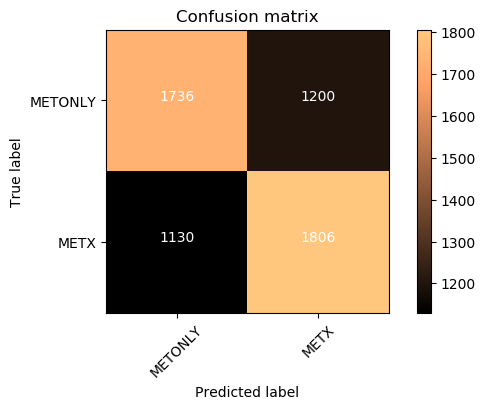

In [55]:
print('Test acc: {:2.3f}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Test AUC: {:2.3f}'.format(metrics.roc_auc_score(y_test, y_pred)))

# Plot non-normalized confusion matrix
plt.figure(dpi=100)
plot_confusion_matrix(cnf_matrix, classes=['METONLY', 'METX'],
                      title='Confusion matrix', cmap=plt.cm.copper)
plt.savefig(root+'/{}-GRAM_cm.png'.format(max_ngram))

# Learning curves

In [8]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure(dpi=100)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel("Training examples")
    plt.ylabel("ROC AUC")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='roc_auc')
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="C0")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="C1")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="C0",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'x-', color="C1",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.tight_layout()
    return plt

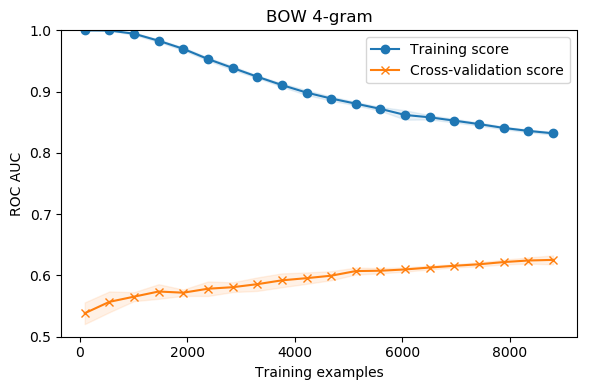

In [9]:
plot_learning_curve(pipe, 'BOW {}-gram'.format(max_ngram),
                    data, labels.values.ravel(), cv=sss, ylim=[0.5, 1],
                    n_jobs=-1, train_sizes=np.linspace(0.01, 1, 20))
plt.savefig(root+'/{}-GRAM_lcurves.png'.format(max_ngram));

# Regularization path

In [56]:
y = labels.values.ravel()

bow = CountVectorizer(analyzer='char', ngram_range=(1, max_ngram))
X = bow.fit_transform(data)
print(X.shape)

(11744, 889)


In [11]:
nC = 100
C_range = np.logspace(-4, 0, nC)

def fitmodel(C):
    return LogisticRegression(penalty='l1', C=C).fit(X, y).coef_

coefs = jl.Parallel(n_jobs=nC)(jl.delayed(fitmodel)(C) for C in C_range)
coefs = np.array(coefs)[:,0,:].T

/home/samu/miniconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


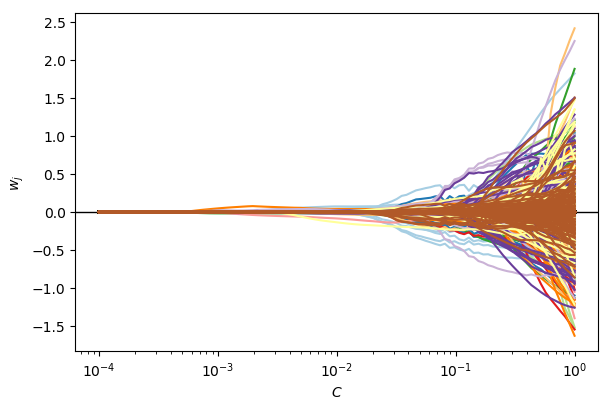

In [12]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)

colormap = plt.cm.Paired
ax.set_color_cycle([colormap(i) for i in np.linspace(0, 1, coefs.shape[0])])
plt.axhline(color='k', linewidth=1, linestyle='solid') # xaxis
feature_map = {bow.vocabulary_[k]: k for k in bow.vocabulary_.keys()}

for i, _coef in enumerate(coefs):
    ax.semilogx(C_range, _coef, label=feature_map[i].upper())
    
# lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.xlabel(r'$C$')
plt.ylabel(r'$w_j$')
plt.savefig(root+'/{}-GRAM_regpath.png'.format(max_ngram), bbox_inches='tight');
#  bbox_extra_artists=(lgd,),

In [13]:
K = 10
first_K_nonzeros = []
for coef in coefs.T:
    nonzeros = np.nonzero(coef)[0]
    for i in nonzeros:
        if len(np.unique(first_K_nonzeros)) < K and feature_map[i].upper() not in first_K_nonzeros:
            first_K_nonzeros.append(feature_map[i].upper())
        else:
            break
print(first_K_nonzeros, file=open(root+'/{}-GRAM_firstKnon0.txt'.format(max_ngram), 'w'))

# Linear feature weight

In [14]:
pipe = Pipeline([
    ('vect', CountVectorizer(analyzer='char', ngram_range=(1, max_ngram))),
    ('clf', LogisticRegression())
    ])

pipe.fit(data, labels.values.ravel())

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='char', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 4), preprocessor=None, stop_words=None,
        str...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

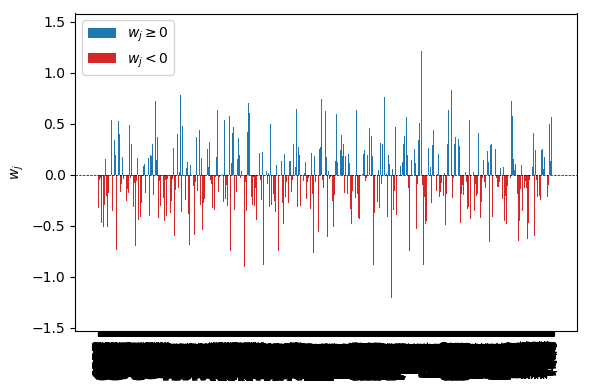

In [15]:
plt.figure(dpi=100)

coef = pipe.steps[1][1].coef_[0]
feature_map = {pipe.steps[0][1].vocabulary_[k]: k for k in pipe.steps[0][1].vocabulary_.keys()}
d = len(feature_map.keys())

xaxis = np.arange(d)
pos_idx = np.where(coef >= 0)[0]
neg_idx = np.where(coef < 0)[0]
plt.bar(xaxis[pos_idx], coef[pos_idx], label=r'$w_j \geq 0$', color='C0') # positive coefs
plt.bar(xaxis[neg_idx], coef[neg_idx], label=r'$w_j < 0$', color='C3') # negative coefs
plt.axhline(color='k', linewidth=0.5, linestyle='dashed')
plt.ylabel(r'$w_j$')
plt.xticks(xaxis, [feature_map[i].upper() for i in range(d)], rotation=90)
plt.legend(loc=2)
plt.tight_layout()
plt.savefig(root+'/{}-GRAM_weights.png'.format(max_ngram), bbox_inches='tight');

# Data viz

In [114]:
max_ngram = 5

pipe = Pipeline([
    ('vect', CountVectorizer(analyzer='char', ngram_range=(1, max_ngram), max_features=512)),
    ('tfidf', TfidfTransformer()),
    ('s2d', FunctionTransformer(lambda sp: sp.toarray(), validate=False)),
    ('pp', Normalizer()),
    ('dr0', PCA(n_components=50)),
    ('dr1', Isomap(n_components=3))
    ])

x_r = pipe.fit_transform(data)

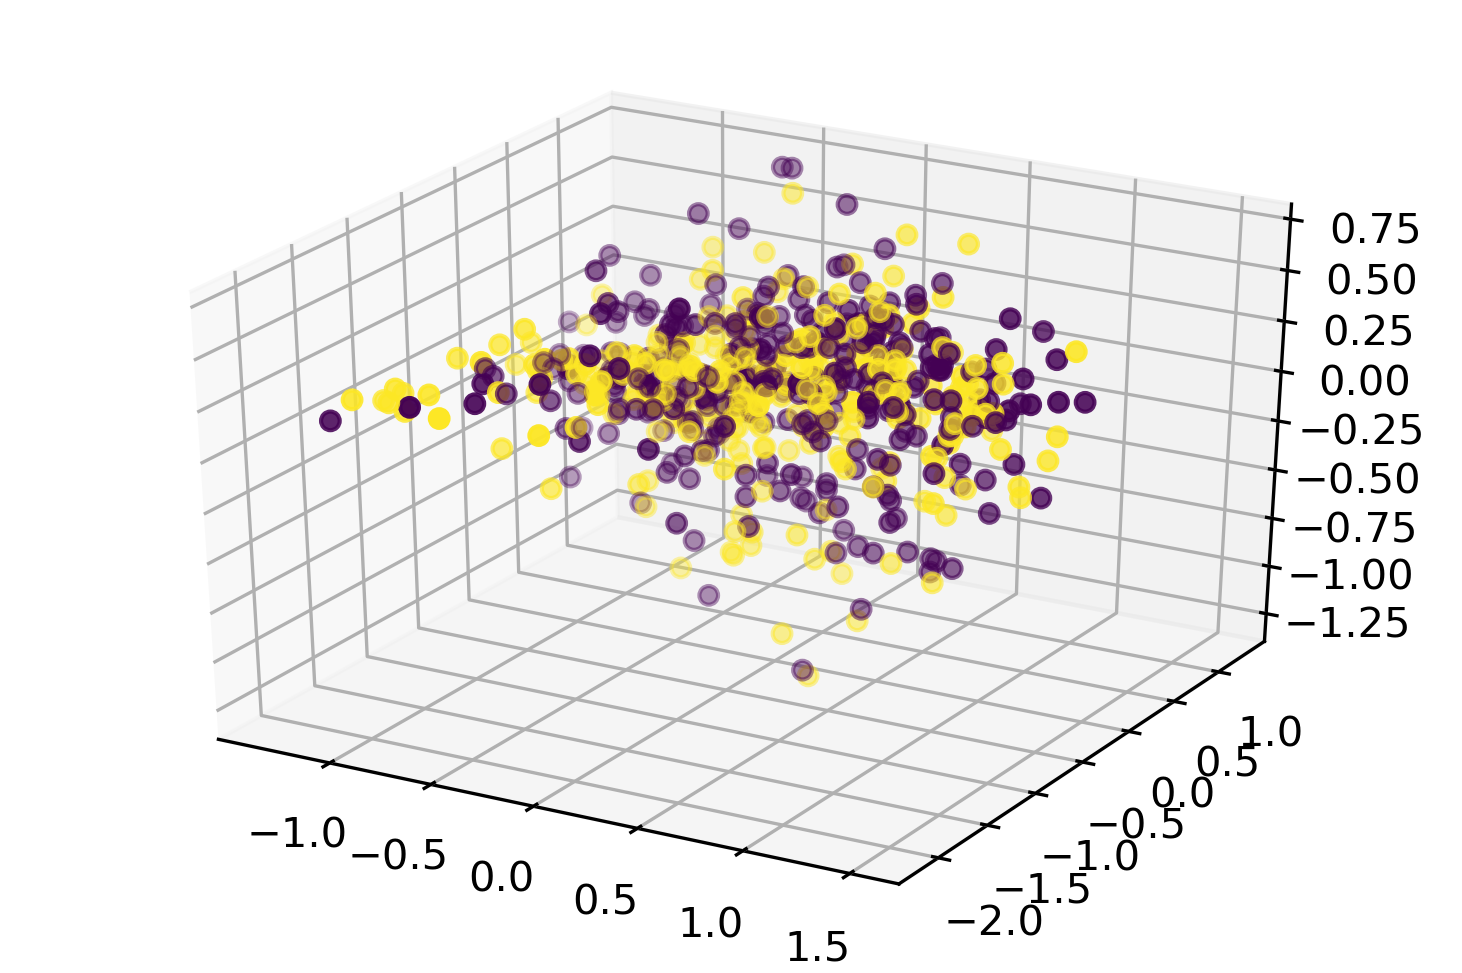

In [115]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')

idx = np.arange(x_r.shape[0])
np.random.shuffle(idx)
idx = idx[:600]

ax.scatter(x_r[idx, 0], x_r[idx, 1], x_r[idx, 2], c=y[idx]);

# Feature boxplot

In [200]:
max_ngram = 3
max_features = 27

y = labels.values.ravel()

pipe = Pipeline([
    ('vect', CountVectorizer(analyzer='char', ngram_range=(1, max_ngram), max_features=max_features)),
    ('s2d', FunctionTransformer(lambda sp: sp.toarray(), validate=False)),
    ('pp', Normalizer())
    ])

X = pipe.fit_transform(data)
feature_map = {pipe.steps[0][1].vocabulary_[k]: k for k in pipe.steps[0][1].vocabulary_.keys()}

In [201]:
df = pd.DataFrame(X, index=labels.index,
                  columns=[feature_map[i] for i in range(X.shape[1])])
df.loc[:, 'class'] = labels['CLASS']
df.head()

,0,0e,0g,0g0,0i,0l,0p,0p0,0t,0t0,...,l,l0,p,p0,p0p,t,t0,t0g,t0t,class
PIN,,,,,,,,,,,,,,,,,,,,,
568483,143,0,31,24,2,54,20,19,36,25,...,56,55,22,21,15,43,32,19,9,1
923748,312,29,83,73,13,22,68,66,81,66,...,35,16,70,68,44,106,91,64,5,0
2035328,134,16,28,18,6,6,57,57,11,11,...,7,4,63,63,46,14,14,9,1,0
2239386,145,5,33,21,11,0,57,55,32,21,...,0,0,68,66,45,38,27,18,4,1
2244533,178,1,51,32,8,0,57,56,51,36,...,0,0,61,60,33,66,51,35,4,1


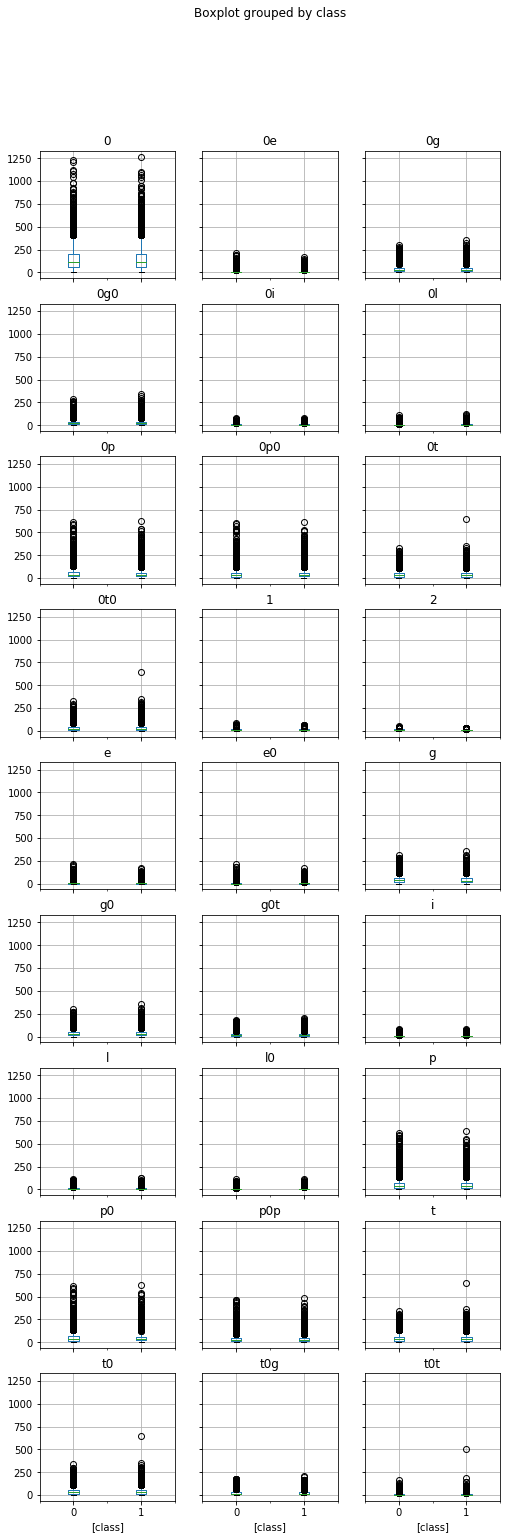

In [202]:
df.boxplot(by='class', layout=(max_features/3, 3), figsize=(8, 25));

# Feature selection
Using simple filter methods.

In [203]:
stat, pval = chi2(df[df.columns.drop('class')], df['class'])
chi2_test = pd.DataFrame(data=np.vstack((stat, pval)).T, index=df.columns.drop('class'), columns=['Stat', 'p-value'])
chi2_test.sort_values(by='p-value')

,Stat,p-value
l0,653.256825,4.373395e-144
0l,538.688891,3.636321e-119
2,498.577253,1.938797e-110
l,321.107587,8.310863e-72
0,149.258045,2.518466e-34
0t0,101.080183,8.833424e-24
0g0,91.412889,1.166144e-21
1,83.701023,5.755543e-20
0e,54.474599,1.574702e-13
e0,53.250245,2.936508e-13


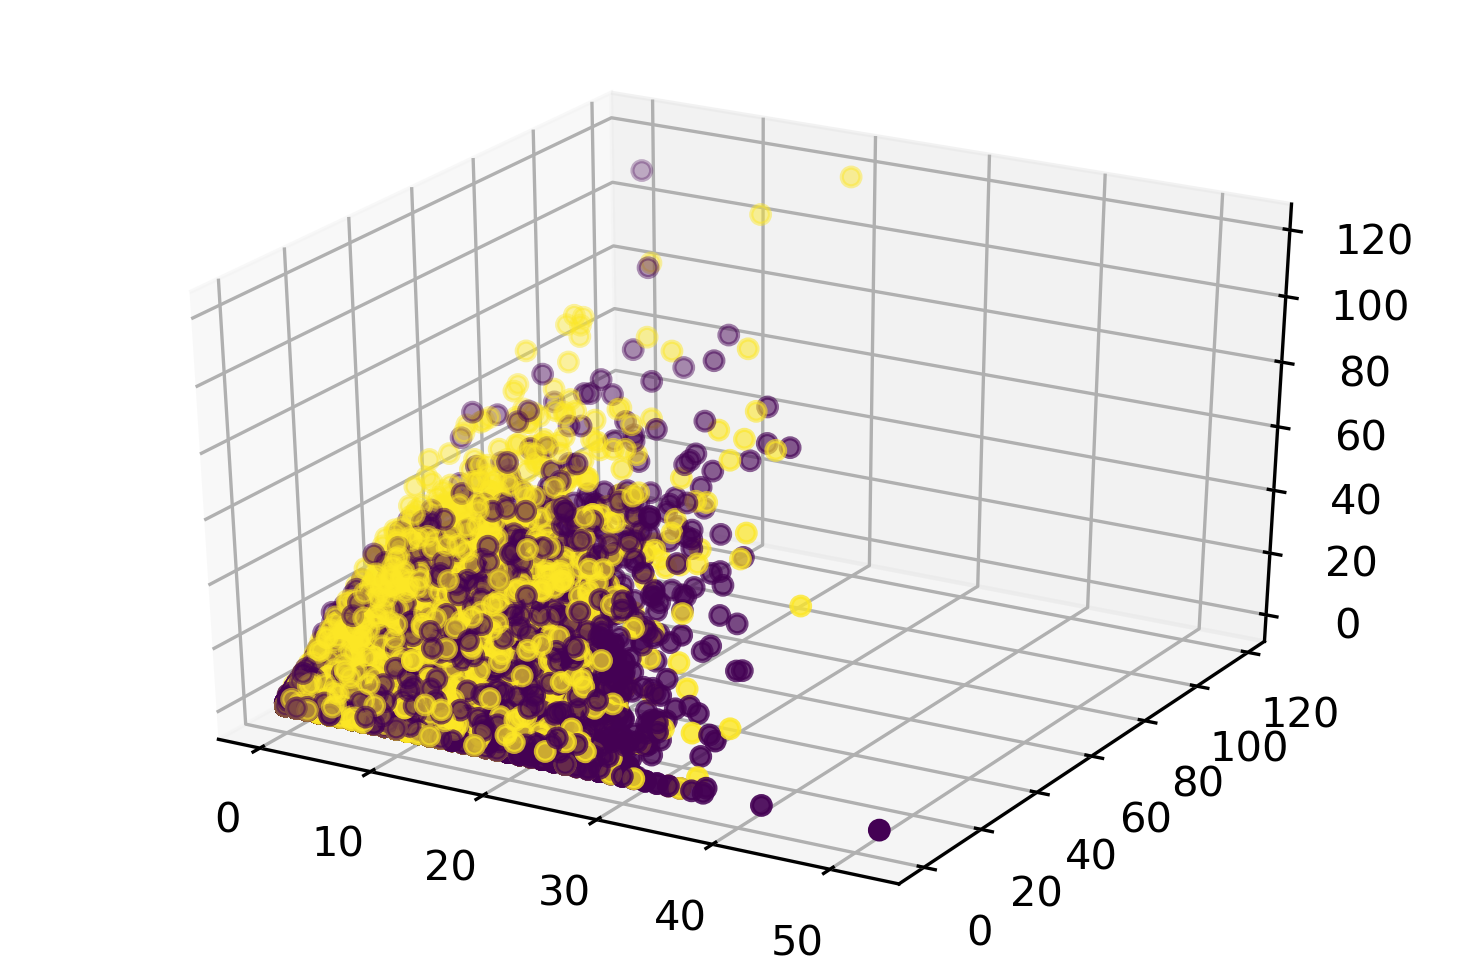

In [204]:
fig = plt.figure(dpi=300)
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['2'], df['l0'], df['0l'], c=df['class']);